In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('salary.csv')

In [4]:
data.shape

(35, 2)

In [5]:
data.head()

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


In [15]:
X = data[['YearsExperience']]
y = data[['Salary']]

In [84]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [86]:
X_train

array([[ 2.9],
       [ 4.9],
       [ 3.7],
       [ 6.8],
       [ 5.9],
       [ 3. ],
       [10.5],
       [ 4.1],
       [ 1.5],
       [11.5],
       [ 8.7],
       [ 7.1],
       [ 7.9],
       [ 2. ],
       [ 9.6],
       [ 5.1],
       [ 3.9],
       [12.9],
       [ 1.1],
       [ 8.2],
       [12.3],
       [ 5.3],
       [ 4.5],
       [10.3],
       [ 4. ],
       [ 9. ]], dtype=float32)

In [33]:
y_train.shape

(26, 1)

In [19]:
X_test.shape

(10, 1)

# SAGEMAKER

In [87]:
import boto3
import sagemaker

# Sagemaker Session
sagemaker_session = sagemaker.Session()

#Execution Role
role = sagemaker.get_execution_role()

# print(role)


In [88]:
y_train = y_train[:,0]

In [89]:
type(y_train)

numpy.ndarray

In [40]:
y_train.shape

(26,)

In [90]:
# Converting input into supported format
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, (X_train), (y_train))
buf.seek(0)

0

In [93]:
# Uploading data to S3
import os

bucket = 'sagemaker-learn111'
prefix = 'linear-learner'
key = 'linear-train-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

ValueError: I/O operation on closed file.

In [95]:
output_location = 's3://{}/{}/output'.format(bucket,prefix)
print(output_location)

s3://sagemaker-learn111/linear-learner/output


In [99]:
# Container Image
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [106]:
linear = sagemaker.estimator.Estimator(container, role, train_instance_count=1,train_instance_type='ml.c4.xlarge',output_path=output_location,sagemaker_session=sagemaker_session)

linear.set_hyperparameters(feature_dim=1, predictor_type='regressor', mini_batch_size=5, epochs=50, num_models=5, loss='absolute_loss')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [107]:
s3_train_data = 's3://{}/{}/train/{}'.format(bucket,prefix,key)

# Training
linear.fit({'train':s3_train_data})

2021-11-18 06:18:11 Starting - Starting the training job...
2021-11-18 06:18:25 Starting - Launching requested ML instancesProfilerReport-1637216291: InProgress
......
2021-11-18 06:19:27 Starting - Preparing the instances for training............
2021-11-18 06:21:39 Downloading - Downloading input data
2021-11-18 06:21:39 Training - Downloading the training image...
2021-11-18 06:22:11 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[11/18/2021 06:22:07 INFO 140709504116544] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_sc

In [108]:
# Deploy
l_r = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------!

In [112]:
#Prediction
from sagemaker.predictor import csv_serializer,json_deserializer

# l_r.content_type = 'text/csv'
l_r.serializer = csv_serializer
l_r.deserializer = json_deserializer

In [113]:
result = l_r.predict(X_test)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [114]:
result

{'predictions': [{'score': 112096.953125},
  {'score': 36656.3984375},
  {'score': 148897.234375},
  {'score': 44936.4609375},
  {'score': 54136.52734375},
  {'score': 61496.58203125},
  {'score': 127737.078125},
  {'score': 79896.71875},
  {'score': 54136.52734375}]}

In [118]:
y_pred = np.array([r['score'] for r in result['predictions']])

In [119]:
y_pred

array([112096.953125  ,  36656.3984375 , 148897.234375  ,  44936.4609375 ,
        54136.52734375,  61496.58203125, 127737.078125  ,  79896.71875   ,
        54136.52734375])

In [120]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Salary vs Experience')

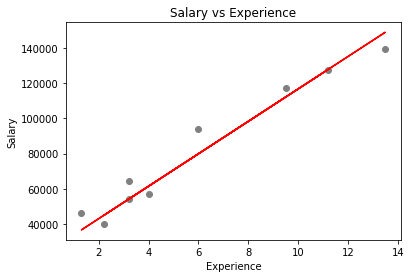

In [124]:
plt.scatter(X_test,y_test, color='grey')
plt.plot(X_test,y_pred, color='red')
plt.xlabel('Experience')
plt.ylabel('Salary')
plt.title('Salary vs Experience')

In [125]:
l_r.delete_enspoint()

AttributeError: 'Predictor' object has no attribute 'delete_enspoint'